# Advanced Lane Line Detection

## Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg

    
class CameraCalibration:
    def __init__(self, nx = 9, ny = 6):
        self.nx = nx
        self.ny = ny
        self.mtx = None
        self.dist = None


    def show_chessboard(self, image_name):
        test_image = cv2.imread(image_name)
        test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(test_image, (nx, ny), None)
        cv2.drawChessboardCorners(test_image_gray, (nx,ny), corners, ret)
        
        plt.imshow(test_image_gray, cmap='gray')
        plt.show()
        
        
    def get_obj_img_points(self, pattern):
        images = glob.glob(pattern)

        # generate an array that has possible point locations e.g. 0,0,0; 0,1,0; 0,2,0
        points = np.float32([[x, y, 0] for y in range(self.ny) for x in range(self.nx)])

        obj_points = []
        img_points = []

        print("Processing all files in folder: ", pattern)

        for filename in images:
            image = cv2.imread(filename)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            ret, corners = cv2.findChessboardCorners(image, (self.nx, self.ny), None)

            if ret:
                obj_points.append(points)
                img_points.append(corners)
            else:
                print('Chessboard cannot find corneres for:', filename)

        print("Calibration done")
        return obj_points, img_points
    

    def calibrate_using_images(self, image_files = './camera_cal/calibration*.jpg', save_to = 'camera_calib.p'):
        obj_points, img_points = self.get_obj_img_points(image_files)
        
        # figure out the image size
        images = glob.glob(image_files)
        image = mpimg.imread(images[0])
        img_size = image.shape[:2]
        print(img_size)
        
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size, None, None)
        if ret:
            with open(save_to, "wb") as f:
                pickle.dump({'mtx': self.mtx, 'dist': self.dist}, f)
                print("mtx and dist arrays have been saved to:", save_to)
        else:
            print("Could not calibrate camera using the given parameters")
    
    def load_calibration(self, from_file = './camera_calib.p'):
        with open(from_file, "rb") as f:
            data = pickle.load(f)
            self.mtx = data['mtx']
            self.dist = data['dist']
            
    def undistort(self, img, useOptimal = False):
        if useOptimal:
            h,  w = img.shape[:2]
            newcameramtx, roi = cv2.getOptimalNewCameraMatrix(self.mtx, self.dist, (w,h), 1, (w,h))

            dst = cv2.undistort(img, self.mtx, self.dist, None, newcameramtx)

            # crop the image
            x,y,w,h = roi
            dst = dst[y:y+h, x:x+w]

            return dst
        else:
            return cv2.undistort(img, self.mtx, self.dist, None, None)

camera = CameraCalibration()
camera.calibrate_using_images()

Processing all files in folder:  ./camera_cal/calibration*.jpg
Chessboard cannot find corneres for: ./camera_cal\calibration1.jpg
Chessboard cannot find corneres for: ./camera_cal\calibration4.jpg
Chessboard cannot find corneres for: ./camera_cal\calibration5.jpg
Calibration done
(720, 1280)
mtx and dist arrays have been saved to: camera_calib.p


## Distortion Test

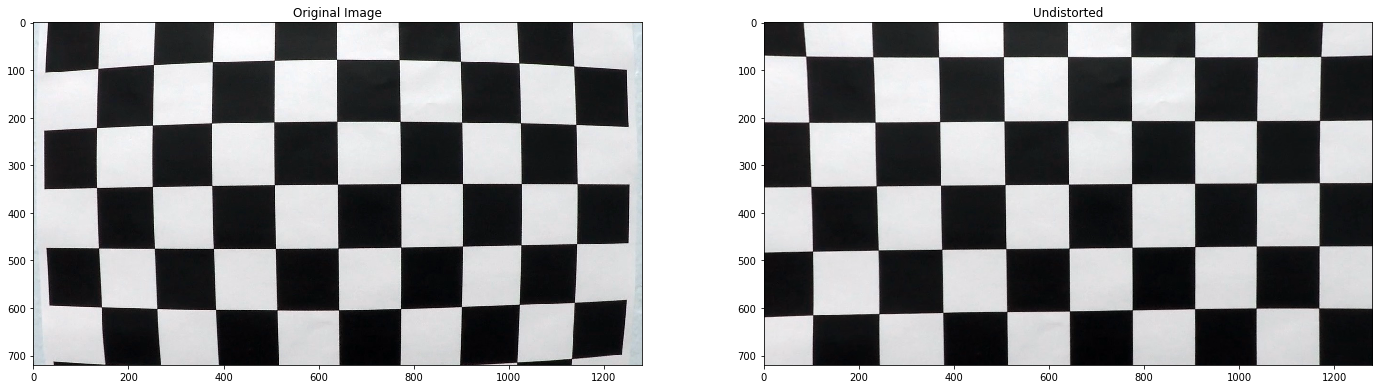

In [2]:
img = cv2.imread('./camera_cal/calibration1.jpg')
dst = camera.undistort(img)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(24, 9))

ax1.imshow(img)
ax1.set_title('Original Image')
ax2.imshow(dst)
ax2.set_title('Undistorted')

plt.show()

## Color Systems

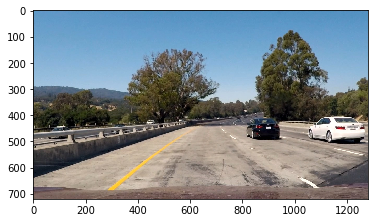

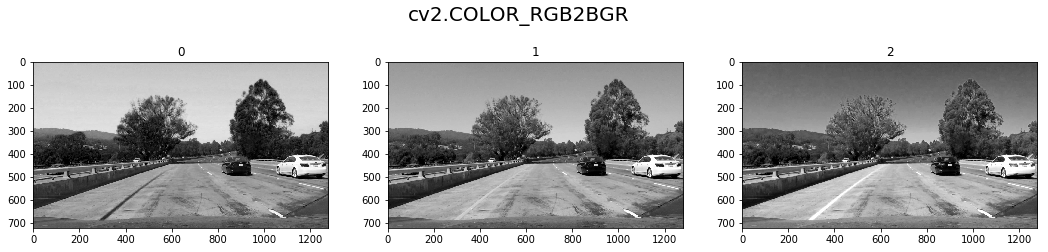

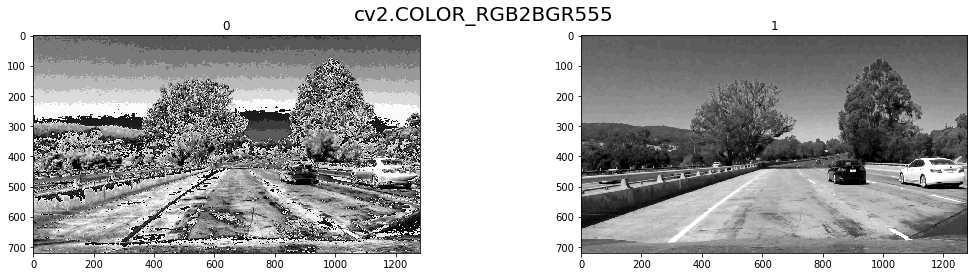

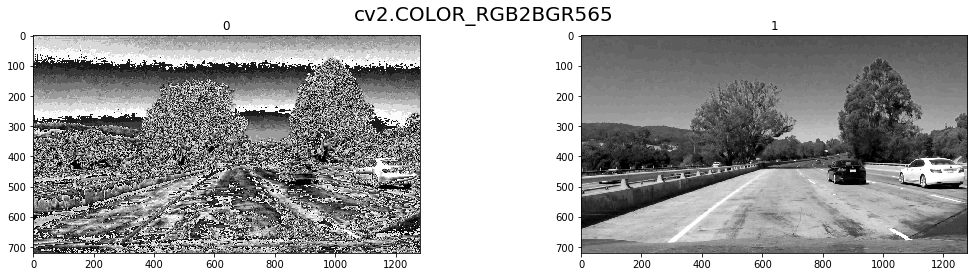

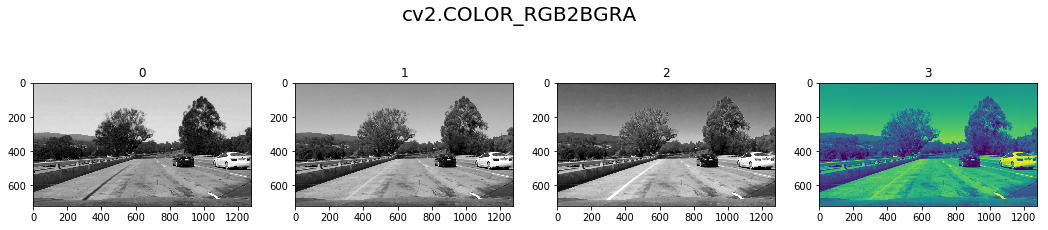

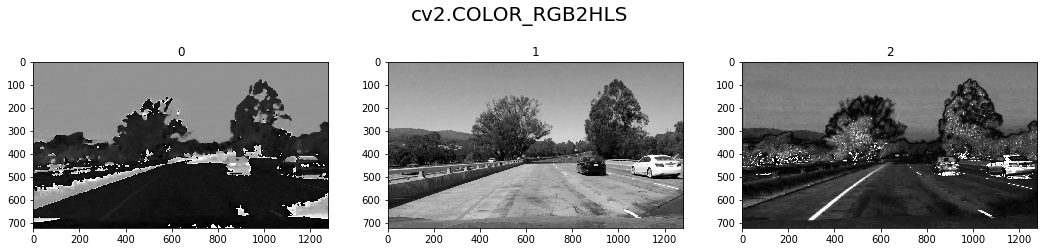

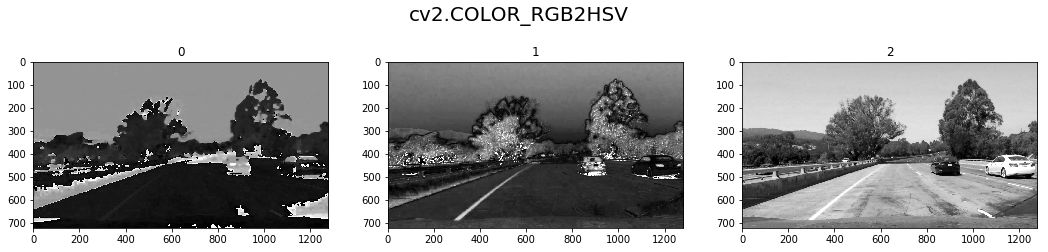

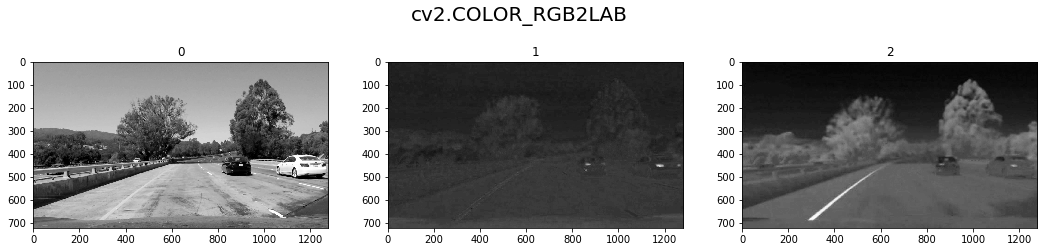

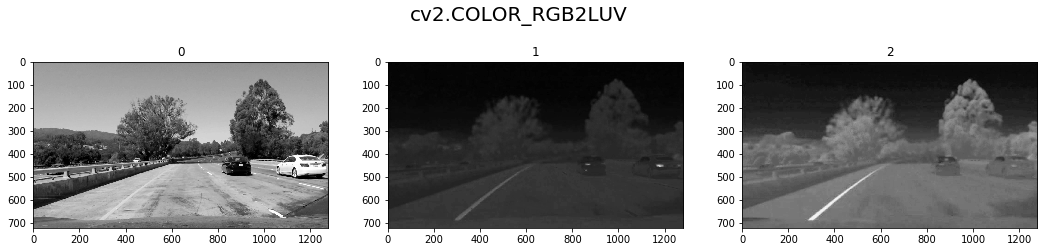

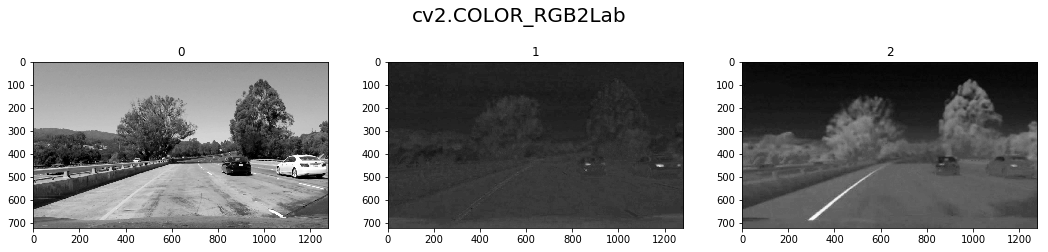

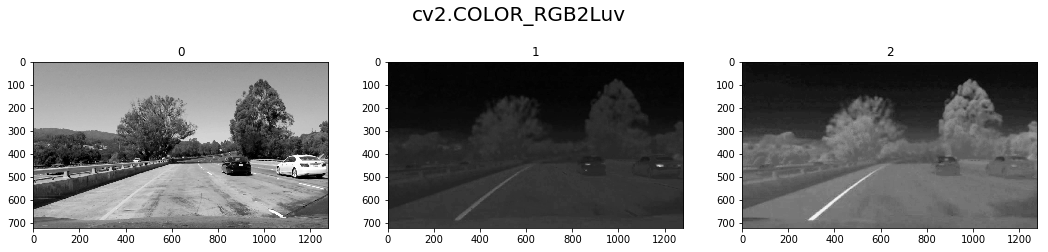

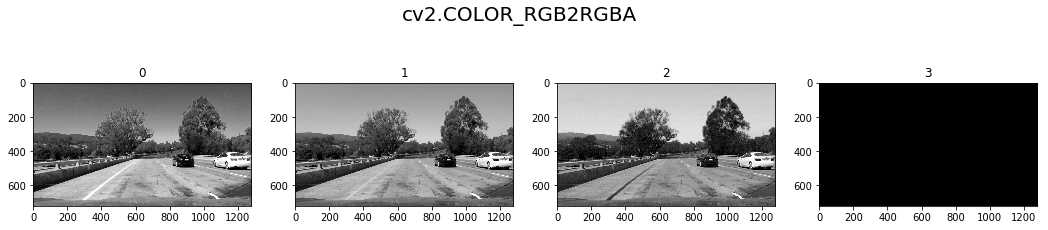

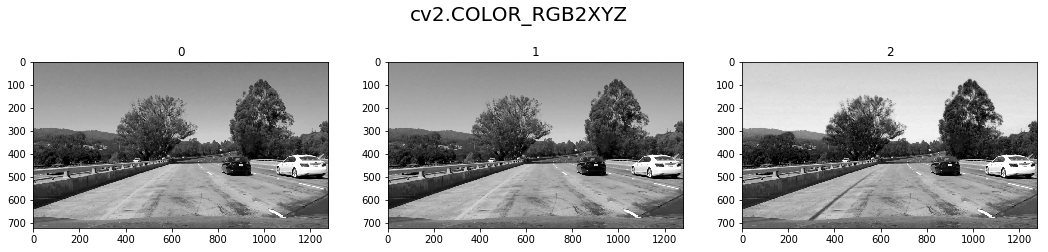

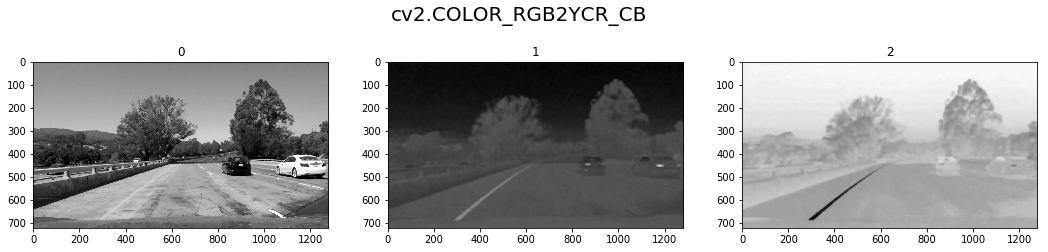

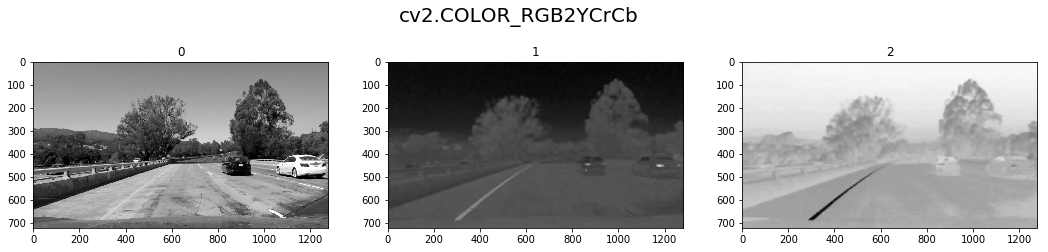

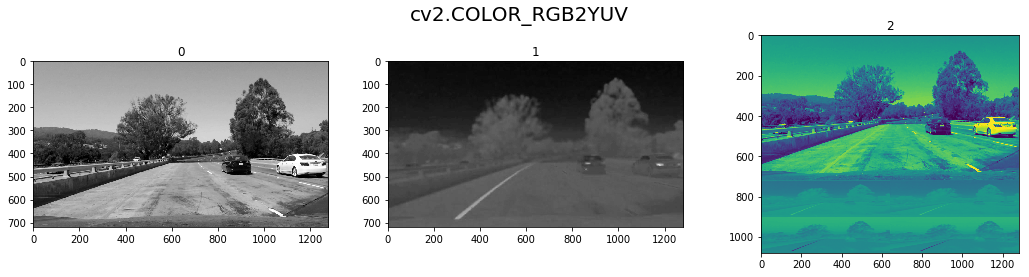

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('./test_images/test1.jpg')

def print_channels(title, channels):

    if len(channels.shape) > 2:
        n_channels = channels.shape[2]
        f, axis = plt.subplots(1, n_channels, figsize=(18,4))
        f.suptitle(title, fontsize=20)
        
        for i in range(n_channels):
            channel = channels[:,:,i]
            axis[i].imshow(channel, cmap='gray')
            axis[i].set_title(i)

        #f.tight_layout()
    else:
        plt.imshow(channels)

def show_all_spaces(img):
    all_spaces = ['cv2.' + i for i in dir(cv2) if i.startswith('COLOR_RGB2') and not i.endswith('_FULL')]
    #print(all_spaces)
    
    for space in all_spaces:
        channels = cv2.cvtColor(img, eval(space)).astype(np.float)
        print_channels(space, channels)

plt.imshow(img)
plt.show()

show_all_spaces(img)
plt.show()

# hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
# print_channels('HLS', hls)

# yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV).astype(np.float)
# print_channels('yuv', yuv)

# luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV).astype(np.float)
# print_channels('luv', luv)

# lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float)
# print_channels('LAB', lab)

# ycbcr = cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB).astype(np.float)
# print_channels('ycr', ycbcr)

# plt.show()

## Edge Detection Functions

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


class EdgeDetection:
    
    def __init__(self, img):
        self.img = img
        self.extract_channels()
        
    def extract_channels(self):
        self.hls = cv2.cvtColor(self.img, cv2.COLOR_RGB2HLS)
        self.lab = cv2.cvtColor(self.img, cv2.COLOR_RGB2LAB)

        self.l = self.lab[:,:,0]
        self.b = self.lab[:,:,2]
        self.s = self.hls[:,:,2]
        
        # remove everything < 200 intensity to 0 in the L channel
        self.l[self.l < 200] = 0

    def abs_sobel_thresh(self, channel, orient='x', sobel_kernel=3, thresh=(0, 255)):
        if orient == 'x':
            sobel = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        else:
            sobel = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

        abs_sobel = np.abs(sobel)
        scaled = np.uint8(255.0 * abs_sobel / np.max(abs_sobel))

        mask = (scaled >= thresh[0]) & (scaled <= thresh[1])

        grad_binary = np.zeros_like(channel)
        grad_binary[mask] = 1
        return grad_binary

    def mag_thresh(self, channel, sobel_kernel=3, mag_thresh=(0, 255)):
        sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

        mag = np.sqrt(sobelx ** 2 + sobely ** 2)
        scaled = np.uint8(255.0 * mag / np.max(mag))

        mask = (scaled >= mag_thresh[0]) & (scaled <= mag_thresh[1])

        mag_binary = np.zeros_like(channel)
        mag_binary[mask] = 1
        return mag_binary

    def dir_threshold(self, channel, sobel_kernel=3, thresh=(0, np.pi/2)):
        sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

        dir_sobel = np.arctan2(np.abs(sobely), np.abs(sobelx))

        mask = (dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])

        dir_binary = np.zeros_like(channel)
        dir_binary[mask] = 1
        return dir_binary

    def get_color_thresh_img(self):
        color_thresh = (170,255)
        
        mask = (self.s >= color_thresh[0]) & (self.s <= color_thresh[1])
        binary = np.zeros_like(self.s)
        binary[mask] = 1
        return binary

    def get_gradient_img(self):
        grad_x = self.abs_sobel_thresh(self.l, 'x', sobel_kernel=7, thresh=(40,120))
        mag = self.mag_thresh(self.s, sobel_kernel=19, mag_thresh=(40, 150))

        mask = (grad_x == 1) | (mag == 1)
        combined = np.zeros_like(self.s)
        combined[mask] = 1
        return combined

    def process_image(self):
        grad = self.get_gradient_img()
        color_threshold = self.get_color_thresh_img()

        combined = np.zeros_like(grad)
        mask = (grad == 1) | (color_threshold == 1)
        combined[mask] = 1
        return combined


## Edge Detection Test

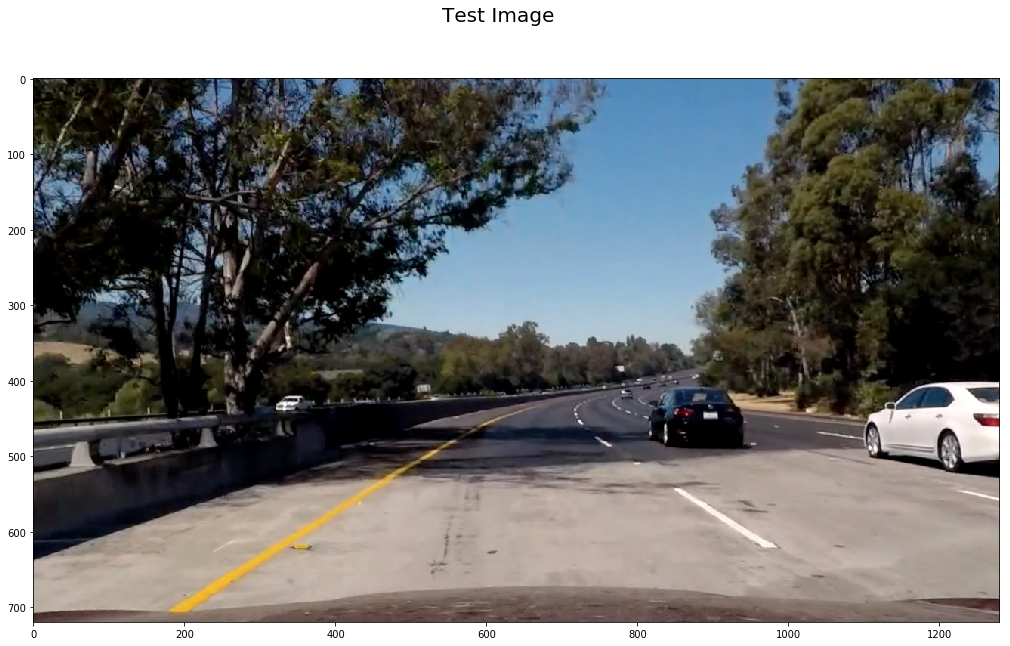

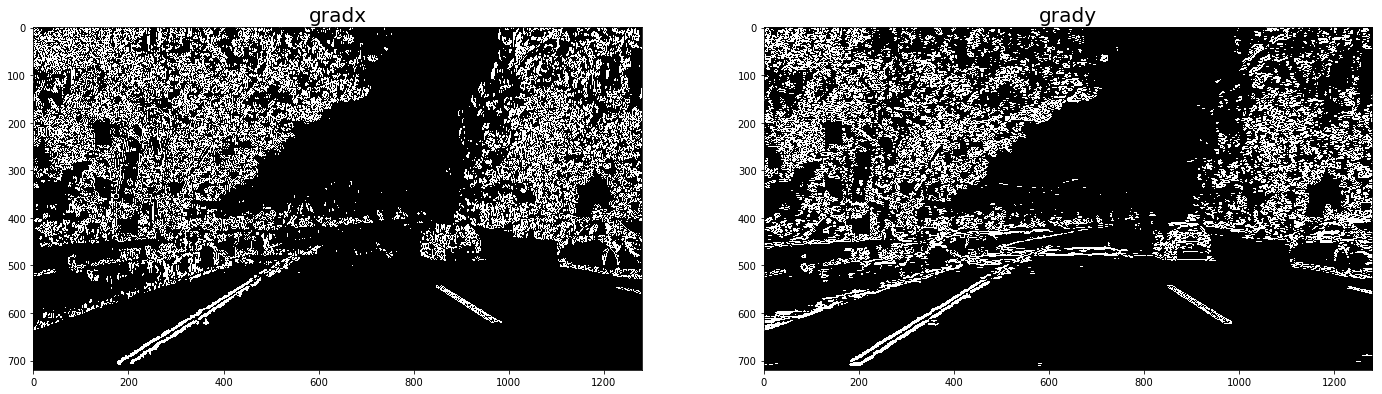

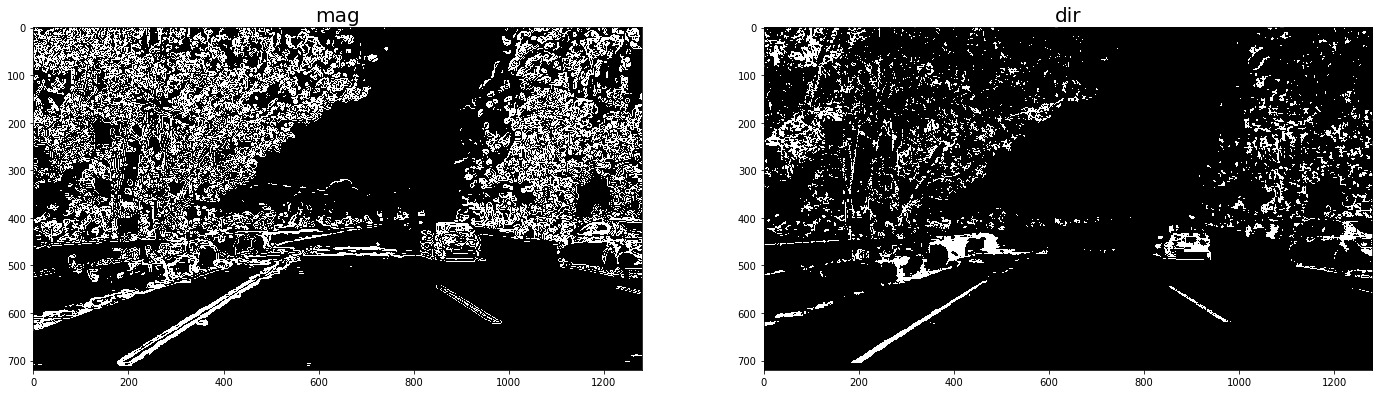

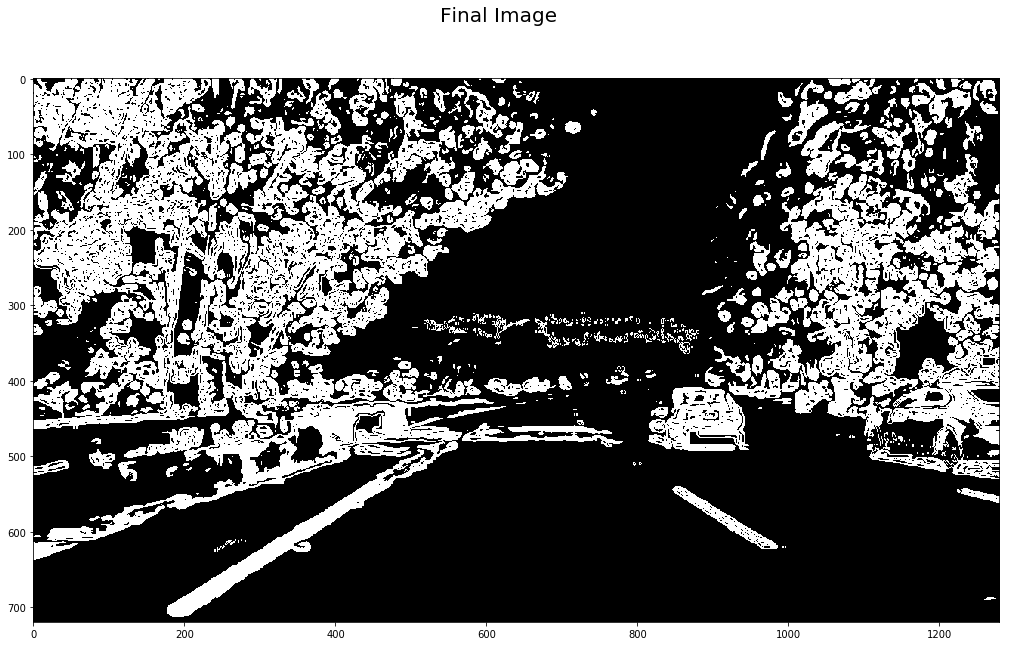

In [5]:
#img = mpimg.imread('./test_images/straight_lines1.jpg')
img = mpimg.imread('./test_images/test5.jpg')
img = camera.undistort(img)

edge = EdgeDetection(img)
ksize = 7

gradx = edge.abs_sobel_thresh(edge.s, orient='x', sobel_kernel=ksize, thresh=(20, 90))
grady = edge.abs_sobel_thresh(edge.s, orient='y', sobel_kernel=ksize, thresh=(30, 140))
mag_binary = edge.mag_thresh(edge.s, sobel_kernel=9, mag_thresh=(30, 90))
dir_binary = edge.dir_threshold(edge.s, sobel_kernel=31, thresh=(45 * np.pi / 180.0, 60 * np.pi / 180))
color_thresh = edge.get_color_thresh_img()

plt.figure(figsize=(20,10))
plt.suptitle('Test Image', fontsize=20)
plt.imshow(img)
plt.show()

f, (ax1, ax2) = plt.subplots(1,2, figsize=(24,9))
ax1.imshow(gradx, cmap='gray')
ax1.set_title('gradx', fontsize=20)
ax2.imshow(grady, cmap='gray')
ax2.set_title('grady', fontsize=20)

f, (ax3, ax4) = plt.subplots(1,2, figsize=(24,9))
ax3.imshow(mag_binary, cmap='gray')
ax3.set_title('mag', fontsize=20)
#ax4.imshow(dir_binary, cmap='gray')
ax4.imshow(color_thresh, cmap='gray')
ax4.set_title('dir', fontsize=20)

final_img = edge.process_image()
plt.figure(figsize=(20,10))
plt.suptitle('Final Image', fontsize=20)
plt.imshow(final_img, cmap='gray')
plt.show()



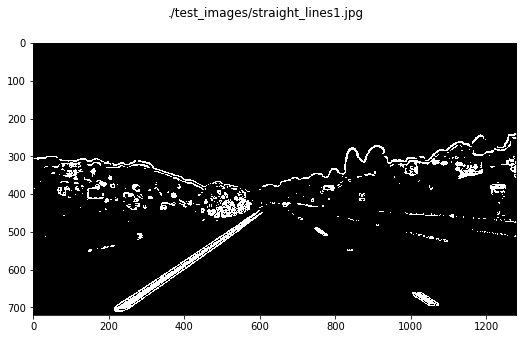

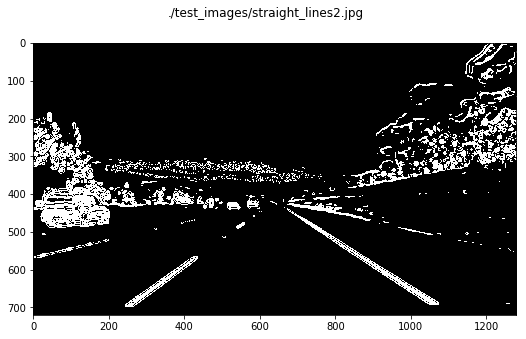

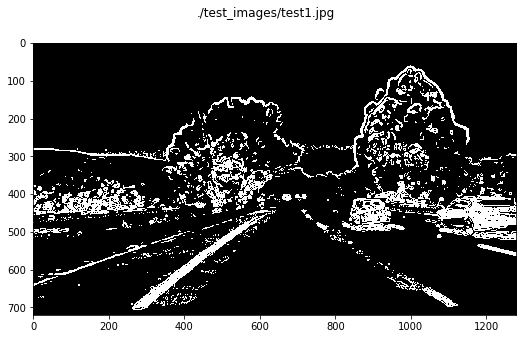

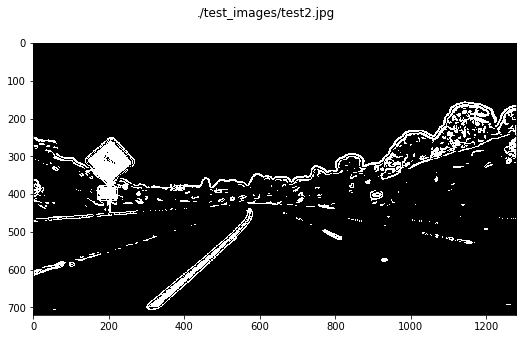

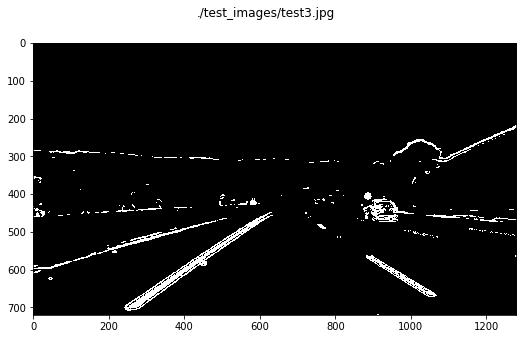

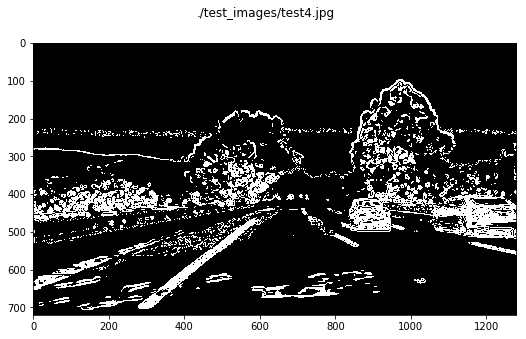

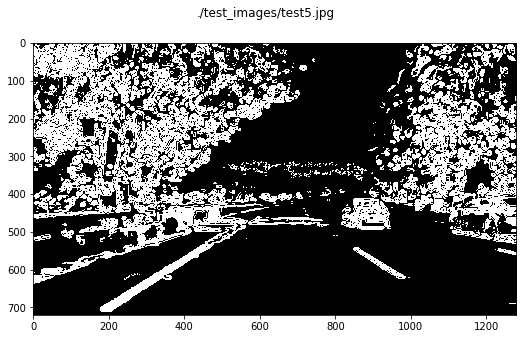

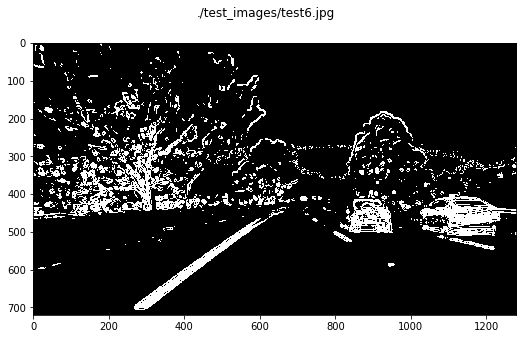

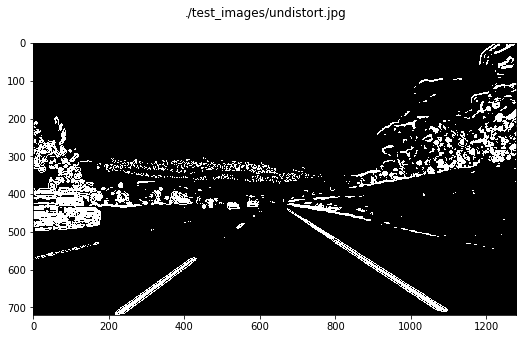

In [7]:
filenames = [os.path.join('./test_images', filename) for filename in os.listdir('./test_images')]
    
for filename in filenames:
    img = mpimg.imread(filename)
    undistort_img = camera.undistort(img)
    
    edge_algo = EdgeDetection(undistort_img)
    edge_img = edge_algo.process_image()
    
    plt.figure(figsize=(10,5))
    plt.suptitle(filename)
    plt.imshow(edge_img, cmap='gray')

plt.show()

# Pipleline

In [6]:
import matplotlib.patches as patches

class LaneDetection:
    
    def __init__(self):
        self.camera = CameraCalibration()
        self.camera.load_calibration()
        self.binary_image = None
        self.binary_warped = None
        
        top_y = 457
        tl_x = 585
        tr_x = 701
        br_x = 1100
        bl_x = 230
        bot_y = 710

        self.src = np.float32([
            [tl_x, top_y],
            [tr_x, top_y],
            [br_x, bot_y],
            [bl_x, bot_y]
        ])

        top_y = 0
        tl_x = bl_x
        tr_x = br_x
        bot_y = 720

        self.dst = np.float32([
            [tl_x, top_y],
            [tr_x, top_y],
            [tr_x, bot_y],
            [tl_x, bot_y]
        ])

        
    def get_warped_image(self, img):
        undistort_img = self.camera.undistort(img)
        edge_algo = EdgeDetection(undistort_img)
        self.binary_img = edge_algo.process_image()
        
        # get image size (width, height)
        img_size = undistort_img.shape[:2][::-1]

        M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.binary_warped = cv2.warpPerspective(self.binary_img, M, img_size, flags = cv2.INTER_LINEAR)
        
        return self.binary_warped
    
    def detect(self, img):
        self.get_warped_image(img)

## Perspective Region Test

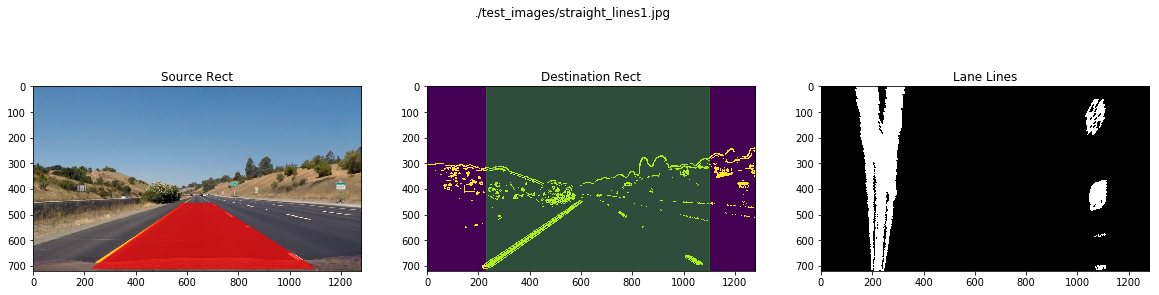

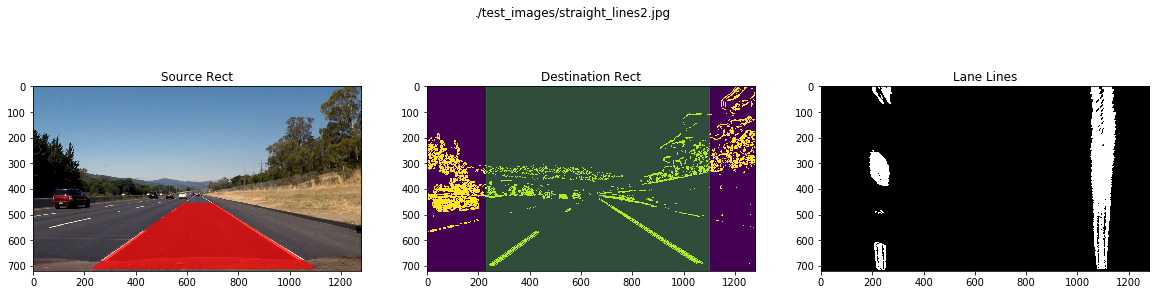

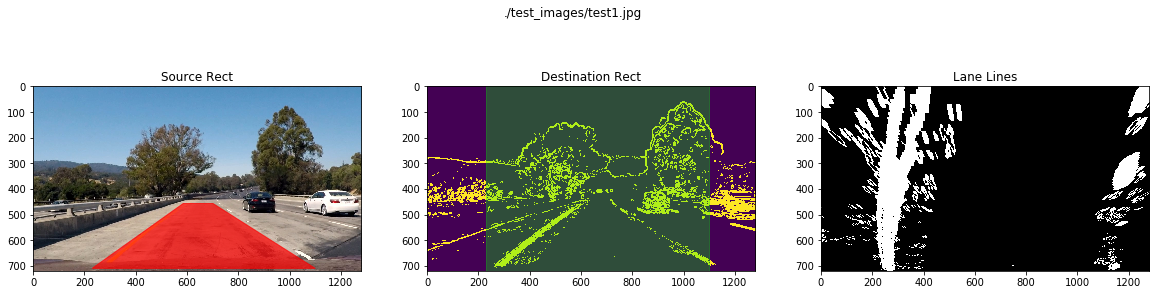

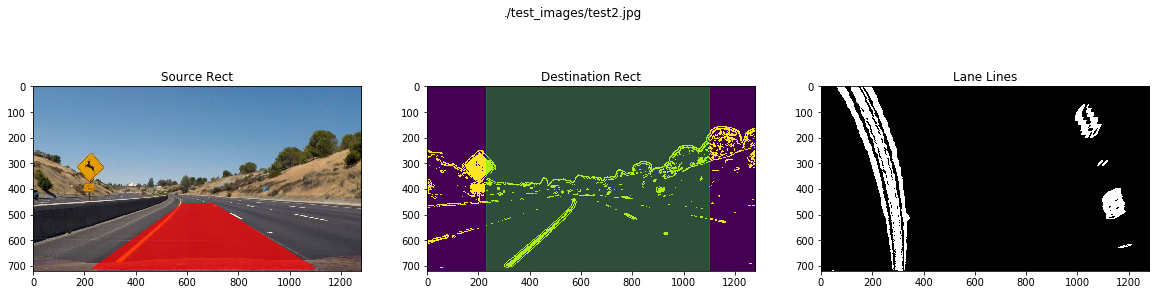

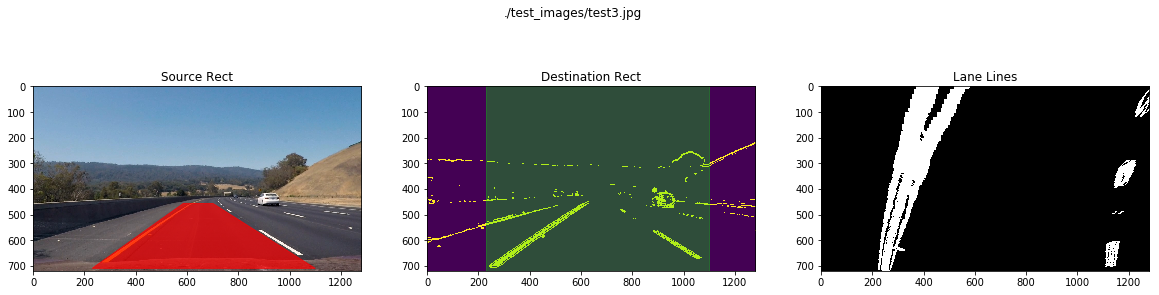

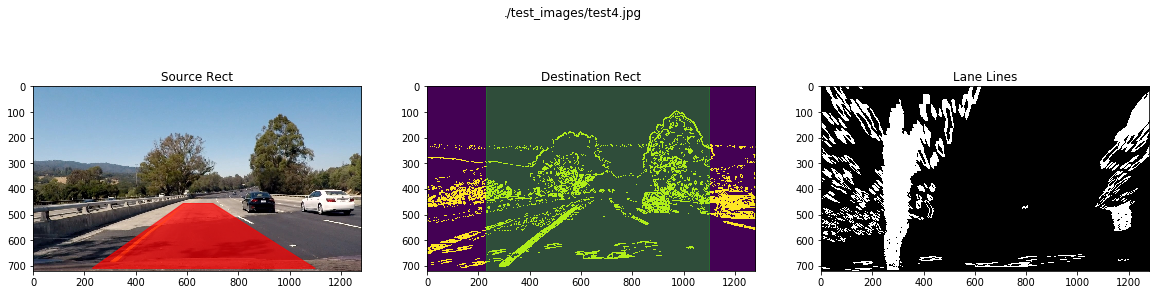

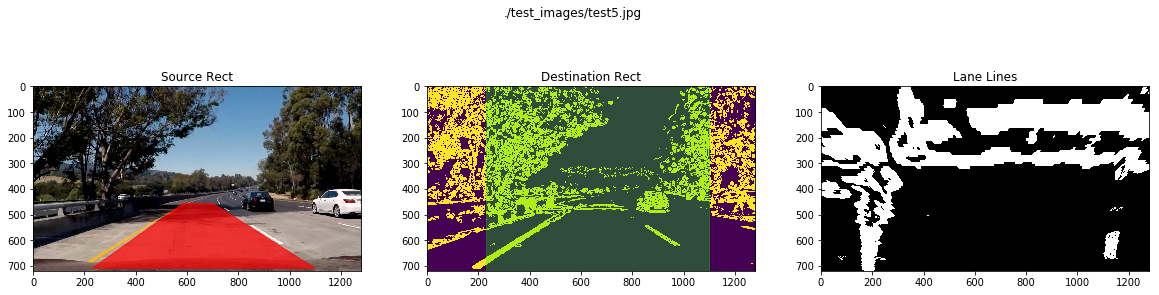

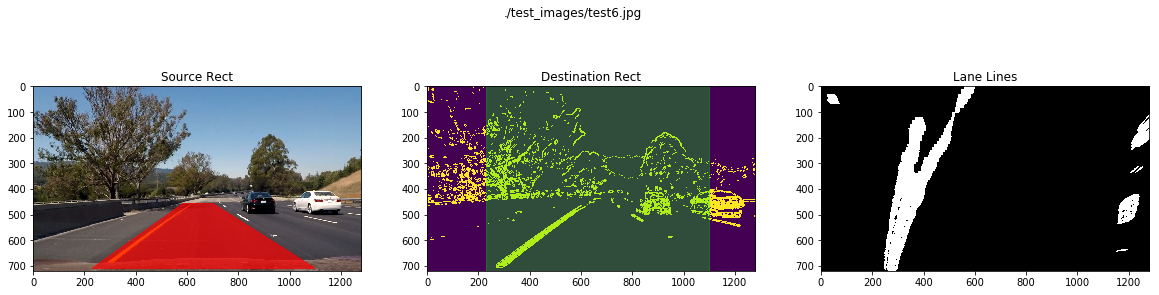

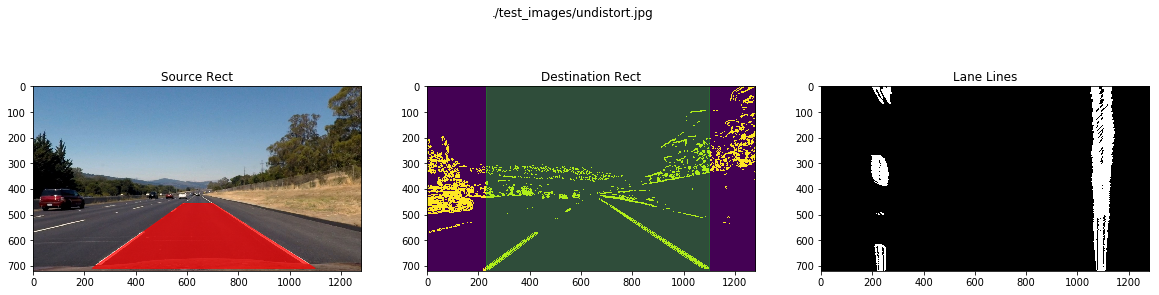

In [12]:
filenames = [os.path.join('./test_images', filename) 
             for filename in os.listdir('./test_images') if not filename.startswith('.')]
filename = filenames[1]

lane_algo = LaneDetection()
    
def test_perspective(filename):
    img = mpimg.imread(filename)

    binary_warped = lane_algo.get_warped_image(img)

    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
    f.suptitle(filename)

    ax1.imshow(img)
    ax1.add_patch(patches.Polygon(lane_algo.src, closed=True, alpha=0.7, color=(1, 0, 0)))
    ax1.set_title('Source Rect')

    ax2.imshow(lane_algo.binary_img)
    ax2.add_patch(patches.Polygon(lane_algo.dst, closed=True, alpha=0.3, color=(0, 1, 0)))
    ax2.set_title('Destination Rect')

    ax3.imshow(binary_warped, cmap='gray')
    ax3.set_title('Lane Lines')

for filename in filenames:
    test_perspective(filename)

plt.show()

## Lane line detection

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

filenames = [os.path.join('./test_images', filename) 
             for filename in os.listdir('./test_images') if not filename.startswith('.')]
filename = filenames[1]
img = mpimg.imread(filename)

lane_algo = LaneDetection()
warped_img = lane_algo.get_warped_image(img)

plt.imshow(warped_img, cmap='gray')
plt.show()

# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

window_centroids = [] # Store the (left,right) window centroid positions per level
window = np.ones(window_width) # Create our window template that we will use for convolutions

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

# First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
# and then np.convolve the vertical image slice with the window template 

# Sum quarter bottom of image to get slice, could use a different ratio
y = int(3/4*warped_img.shape[0])
mid = int(warped_img.shape[1]/2)

l_bottom_img = warped_img[y:,:mid]

plt.imshow(l_bottom_img, cmap='gray')
plt.show()

l_sum = np.sum(l_bottom_img, axis=0)
conv = np.convolve(window, l_sum)
conv_max = np.argmax(conv)

l_left = conv_max - window_width / 2

print(l_sum.shape)
print(conv_max)

# l_center = np.argmax(np.convolve(window,l_sum))-window_width/2

# r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
# r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

# # Add what we found for the first layer
# window_centroids.append((l_center,r_center))

# # Go through each layer looking for max pixel locations
# for level in range(1,(int)(warped.shape[0]/window_height)):
#     # convolve the window into the vertical slice of the image
#     image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
#     conv_signal = np.convolve(window, image_layer)
#     # Find the best left centroid by using past left center as a reference
#     # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
#     offset = window_width/2
#     l_min_index = int(max(l_center+offset-margin,0))
#     l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
#     l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
#     # Find the best right centroid by using past right center as a reference
#     r_min_index = int(max(r_center+offset-margin,0))
#     r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
#     r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
#     # Add what we found for that layer
#     window_centroids.append((l_center,r_center))

#window_centroids = find_window_centroids(warped, window_width, window_height, margin)



NameError: name 'LaneDetection' is not defined

In [ ]:
# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()
